**Practical Statistics in Python for Engineers**

The purpose of this page is to showcase methods engineers can use to apply statistical rigor to their analyses.

1. [Understanding the data](#understand)
2. [Statistical Power](#stat_power)
3. [Comparing Dataset Means](#comp_mean)
4. [Testing Catagorical Data](#test_cat)




In [1]:
# Imports
import pandas as pd
import scipy.stats as sps
import numpy as np
# import scikit_posthocs

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.power import FTestAnovaPower
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.power import TTestPower
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# Understanding the data
<a id='understand'></a>

First save your data as Pandas dataframes

In [2]:
# Example dataset as Pandas dataframe

x1 = np.concatenate((np.random.normal(10, 2, int(0.3 * 1000)),
                    np.random.normal(6, 1.5, int(0.7 * 1000))))[:, np.newaxis]

x2 = np.concatenate((np.random.normal(9, 2.1, int(0.3 * 1000)),
                    np.random.normal(2, 1.9, int(0.7 * 1000))))[:, np.newaxis]

x3 = np.concatenate((np.random.normal(9.99, 2.01, int(0.3 * 1000)),
                    np.random.normal(6.001, 1.51, int(0.7 * 1000))))[:, np.newaxis]


dataset1 = pd.DataFrame(x1, columns=['value'])
dataset2 = pd.DataFrame(x2, columns=['value'])
dataset3 = pd.DataFrame(x3, columns=['value'])

dataset1.head()

,value
0,9.318024
1,9.088014
2,7.443979
3,11.381269
4,9.657995


Plot data to see what it looks like.

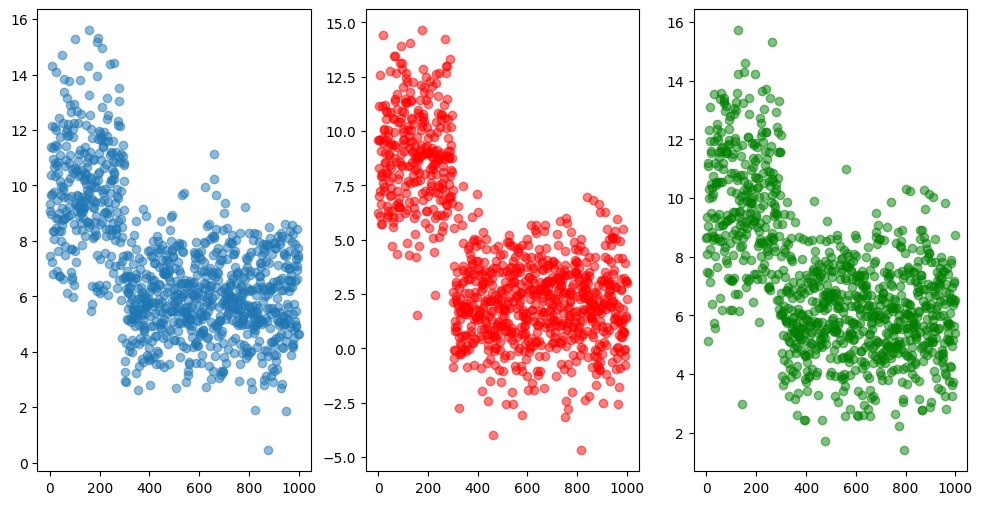

In [3]:
fig, ax = plt.subplots(1,3, figsize=[12,6])

ax[0].scatter(dataset1.index, dataset1, alpha=0.5)
ax[1].scatter(dataset2.index, dataset2, alpha=0.5, color='red')
ax[2].scatter(dataset3.index, dataset3, alpha=0.5, color='green')

Plot and compare dataset distributions. In many cases it will already to easy to tell if the data is normally distributed. In this case,the data appears to be bimodal meaning that tests assuming normal populations should not be used.

C:\ProgramData\Miniconda3\envs\General\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
C:\ProgramData\Miniconda3\envs\General\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
C:\ProgramData\Miniconda3\envs\General\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


[None, None, None, None, None, None]

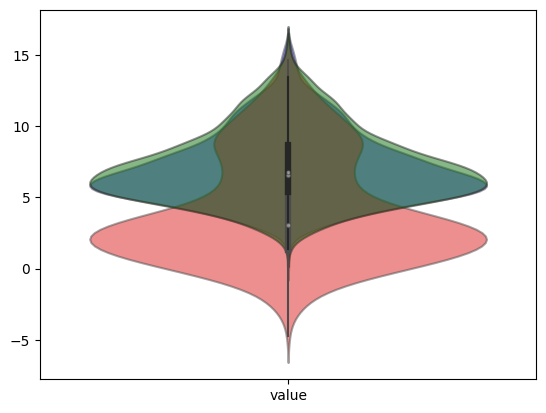

In [4]:
ax = sns.violinplot(dataset1, color='blue')
ax = sns.violinplot(dataset2, color='red')
ax = sns.violinplot(dataset3, color='green')
plt.setp(ax.collections, alpha=0.5)

# Statistical Power
<a id='stat_power'></a>

Statistical power is the probability of making a type II error (wrongly failing to reject the null hypothesis). As the power increases, the probabaly of falsely failing to reject the null hypothesis decreases. Calculating the power before collecting a full dataset can tell you the sample size or effect size required to have a significant result in the experiment.

Effect size for hypothesis tests can be defined by the difference between two means divided by the standard deviation of the data. For the Cohen's d definition:

$d = \frac{\bar{x}_1 - \bar{x}_2} s= \frac{\mu_1 - \mu_2} s$

In [5]:
from IPython.display import SVG, Image
Image(url='https://upload.wikimedia.org/wikipedia/commons/1/15/Cohens_d_4panel.svg', width = 300, height = 300)

In [6]:
est_effect_size = (np.mean(dataset1)-np.mean(dataset2))/np.std(dataset1)
print(f'Effect size: {est_effect_size[0]:.3f}')

Effect size: 1.211


C:\ProgramData\Miniconda3\envs\General\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


A method called *NormalIndPower* can be used to calculate the power for normally distributed hypothesis tests known as Z-tests.

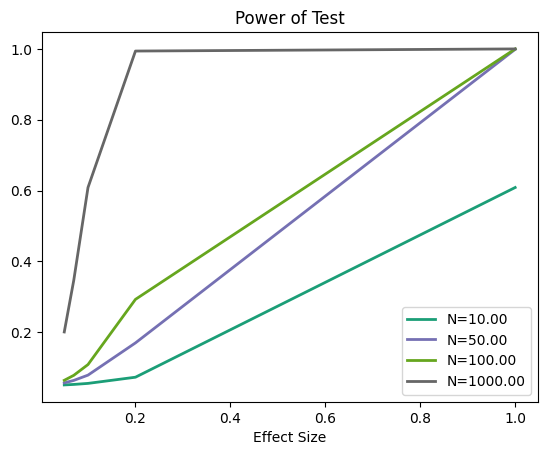

In [7]:
power_per_sample_size_z_test = NormalIndPower().plot_power(dep_var='effect_size', nobs=[10, 50, 100, 1000], effect_size=np.array([0.05, 0.07, 0.1, 0.2, 1]))

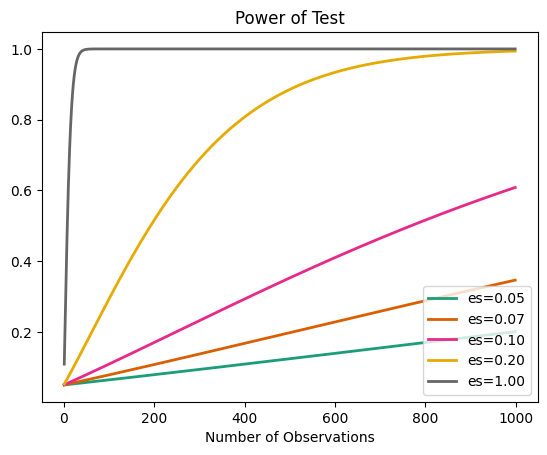

In [8]:
power_per_effect_sizes_z_test = NormalIndPower().plot_power(dep_var='nobs', nobs=np.arange(1, 1000), effect_size=np.array([0.05, 0.07, 0.1, 0.2, 1]))

# Testing for distribution fit

## Testing for Normality

### D’Agostino and Pearson’s test

The purpose of this test is to check if the dataset is suffuciently normal to use parametric methods. If the P value is less than a chosen alpha value then the null hypothesis can be rejected and the distribution is not normal.

>Null hypothesis: x comes from a normal distribution
>* Reject null hypothesis if p-value < $\alpha$ ; choose $\alpha$ = 1e-3 (per scipy documentation)
>* If p-value < alpha then dataset is **not** a normal distribution
    
>Assumptions:
>* none

>Returns: 
>* statistic: $s^2 + k^2$, where s is the z-score returned by skewtest and k is the z-score returned by kurtosistest.
>* pvalue: float of the p-value

In [9]:
norm_test_stat, norm_test_pval = sps.normaltest(dataset1['value'])
print(f'p-value for test of normality: {norm_test_pval:.4e}')
norm_test_alpha = 0.001

if norm_test_pval < norm_test_alpha:
    print('The null hypothesis is rejected. The distribution is likely NOT normal.')
else:
    print('The null hypothesis is not rejected. The distribution IS likely normal.')

p-value for test of normality: 1.2012e-17
The null hypothesis is rejected. The distribution is likely NOT normal.


### Shapiro-Wilk test

https://statistics.laerd.com/spss-tutorials/testing-for-normality-using-spss-statistics.php#:~:text=How%20do%20we%20know%20this,deviate%20from%20a%20normal%20distribution.

https://www.itl.nist.gov/div898/handbook/prc/section2/prc213.htm

Tests for normality of data assuming a small dataset of <2000, or ideally < 50.

>Null hypothesis: x comes from a normal distribution
>* Reject null hypothesis if p-value < $\alpha$ ; typically choose $\alpha$ = 0.05 
>* If p-value < alpha then dataset is **not** a normal distribution
    
>Assumptions:
>* none

>Returns: 
>*

In [10]:
shapiro_stat, shapiro_pval = sps.shapiro(dataset1['value'])
print(f'p-value for test of normality: {shapiro_pval:.4e}')
norm_test_alpha = 0.05

if shapiro_pval < norm_test_alpha:
    print('The null hypothesis is rejected. The distribution is likely NOT normal.')
else:
    print('The null hypothesis is not rejected. The distribution IS likely normal.')

p-value for test of normality: 9.7456e-16
The null hypothesis is rejected. The distribution is likely NOT normal.


## Tests for other distributions

### Anderson-Darling Test

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html#scipy.stats.anderson

https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.normal_ad.html

### Kolmogorov-Smirnov Test

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest

# Testing for statistically different means for different datasets
<a id='comp_mean'></a>

## Tests for normal distributions (parametric methods)

### Independent two-sided t-test

Test checks if two independant samples have identical mean (expected) values. The test should *NOT* be used for more than two datasets as the probability of a significant result decreases.

>Null hypothesis: Two datasets have identical means
>* Reject null hypothesis if p-value < alpha. Alpha is commonly chosen to be 0.05
>* If p-value < alpha then means of dataset are likely not the same

>Inputs:
>* dataset 1, dataset 2

>Returns:
>* t_statistic: distance above or below sample mean
>* p-value

>Assumptions:
>* Normal distibutions
>* Independant samples
>* Equal population variance (unless using Welch's t-test)

In [12]:
t_test_alpha = 0.05  # criteria for significance

t_test_stat, t_test_pval = sps.ttest_ind(dataset1['value'], dataset2['value'])
print(f'p-value for independ two-sided t-test: {t_test_pval:.4e}')

if t_test_pval < t_test_alpha:
    print('Null hypothesis is rejected. The means of the datasets are likely NOT the same')
else:
    print('Null hypothesis cannot be rejected. The means of the datasets are likely to be the same')

p-value for independ two-sided t-test: 2.2751e-89
Null hypothesis is rejected. The means of the datasets are likely NOT the same


In [ ]:
num_obs = [10, 50, 100, 1000]  # number of observations
effect_sizes = np.arange(0, 1, 0.01) # range of effect sizes

power_per_sample_size_t_test = TTestIndPower().plot_power(dep_var='effect_size', nobs=num_obs, 
                                                          effect_size=effect_sizes, title="Power of Independent t-test")
power_per_sample_size_t_test = TTestPower().plot_power(dep_var='effect_size', nobs=num_obs, 
                                                       effect_size=effect_sizes, title="Power of Welch's t-test")


In [ ]:
num_obs = np.arange(2, 1000) # Make sure num_obs is at least 2, otherwise error will be returned (it also doesn't make sense to test for independence of a single observation)
effects = np.array([0.05, 0.07, 0.1, 0.2, 1])

power_per_effect_sizes_t_test = TTestIndPower().plot_power(dep_var='nobs', nobs=num_obs, effect_size=effects,
                                                          title="Power of Independent t-test")
power_per_effect_sizes_t_test = TTestPower().plot_power(dep_var='nobs', nobs=num_obs, effect_size=effects)

In [ ]:
power_per_sample_size_t_test = TTestPower().plot_power(dep_var='effect_size', nobs=[10, 50, 100, 1000], effect_size=np.array([0.05, 0.07, 0.1, 0.2, 1]))

### Welch's t-test

### One-way ANOVA (Analysis of Variance) Test

Tests the hypothesis that two or more groups (of same or differing sizes) have the same population mean. Cannot tell which datasets are different from each other, just that at least one is different.

>Null hypothesis: Datasets have identical means
>* Reject null hypothesis if p-value < alpha. Alpha is commonly chosen to be 0.05
>* If p-value < alpha then means of datasets are not the same

>Inputs:
>* Multiple datasets

>Assumes:
>* The samples are independent
>* Each sample is from a normally distributed population
>* The population standard deviations of the groups are all equal
>* Variances between datasets are equal

>Returns:
>* statistic: float of the computed F-value of the test
>* pvalue: p-value from the F-distribution

It is a good idea to check the standard deviation of the datasets being compared to ensure they are reasonably close to each other.

In [ ]:
std_ratio_1_2 = np.std(dataset1['value']) / np.std(dataset2['value'])
std_ratio_1_3 = np.std(dataset1['value']) / np.std(dataset3['value'])
std_ratio_2_3 = np.std(dataset2['value']) / np.std(dataset3['value'])
print(f'{std_ratio_1_2:.3f}, {std_ratio_1_3:.3f}, {std_ratio_2_3:.3f}')

In [ ]:
power_per_sample_size_anova = FTestAnovaPower().plot_power(dep_var='effect_size', nobs=[10, 50, 100, 1000], effect_size=np.array([0.05, 0.07, 0.1, 0.2, 1]))

In [ ]:
power_per_effect_size_anova = FTestAnovaPower().plot_power(dep_var='nobs', nobs=np.arange(3,1000), effect_size=np.array([0.05, 0.07, 0.1, 0.2, 1]))

In [ ]:
f_test_power = FTestAnovaPower().power(effect_size=est_effect_size, nobs=len(dataset1), alpha=0.05, k_groups=3)
print(f_test_power)

In [ ]:
anova_alpha = 0.05

fstat, f_pval = scipy.stats.f_oneway(dataset1['value'], dataset2['value'], dataset3['value'])
print(f'p-value for ANOVA test: {f_pval:.4e}')

if f_pval < anova_alpha:
    print('Null hypothesis is rejected. The means of the datasets are likely NOT the same')
else:
    print('Null hypothesis cannot be rejected. The means of the datasets are likely to be the same')

### Tukey's Range Test 

Calculates all pairwise comparisons with TukeyHSD confidence intervals. Determines which datasets are significantly different from each other. It is a post-hoc test and should be used if ANOVA predicted significant differences.

>Null hypothesis: Datasets have identical means
>* Reject null hypothesis if p-value < alpha. Alpha is commonly chosen to be 0.05
>* If p-value < alpha then means of datasets are not the same

>Inputs:
>* Multiple datasets appended into a single dataset
>* List of labels for each value in dataset

>Assumes:
>* The samples are independent
>* Each sample is from a normally distributed population

>Returns:
>* Table of pairwise p-values
>* Pairwise rejection of null hypothesis
>* Family-wise error rate (FWER)
>* Lower and upper values

In [ ]:
labels = ['d1']*len(dataset1) + ['d2']*len(dataset2) + ['d3']*len(dataset3)
data = dataset1.append([dataset2, dataset3])

tukey_test = pairwise_tukeyhsd(data, labels)
print(tukey_test)

## Tests for non-normal distributions (non-parametric)

### Wilcoxon Signed-Rank Test

The Wilcoxon signed-rank test tests the null hypothesis that two **related** paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test. A Wilcoxon signed-rank test is a nonparametric test that can be used to determine whether two dependent samples were selected from populations having the same distribution. 

In [ ]:
wilcoxon_alpha = 0.05

wilcoxon_stat, wilcoxon_pval = scipy.stats.wilcoxon(dataset1['value'], y=dataset3['value'])
print(f'Wilcoxon signed-rank test: {wilcoxon_pval:.4e}')
if wilcoxon_pval < wilcoxon_alpha:
    print('Null hypothesis is rejected. The means of the datasets are likely NOT the same')
else:
    print('Null hypothesis cannot be rejected. The means of the datasets are likely to be the same')

### Kruskal H-test for independent samples

The Kruskal hypothesis test is a non-parametric version of ANOVA. It compares the means of all of the datasets 
and provides a p-value predicting whether or not all of the means are the same.

>Null hypothesis: Datasets have identical means
>* Reject null hypothesis if p-value < alpha. Alpha is commonly chosen to be 0.05
>* If p-value < alpha then means of datasets are not the same

>Inputs:
>* Multiple datasets

>Assumes:
>* H has a chi square distribution, the number of samples in each group must not be too small. A typical rule is that each sample must have at least 5 measurements

>Returns:
>* statistic: Kruskal-Wallis H statistic, corrected for ties
>* pvalue: p-value

In [ ]:
kruskal_alpha = 0.05

kruskal_stat, kruskal_pval = scipy.stats.kruskal(dataset1, dataset2, dataset3)
print(f'Kruskal H-test p-value: {kruskal_pval:.4e}')

if kruskal_pval < kruskal_alpha:
    print('Null hypothesis is rejected. The means of the datasets are likely NOT the same')
else:
    print('Null hypothesis cannot be rejected. The means of the datasets are likely to be the same')

### Dunn Post-hoc Comparison

Dunn post comparison is a non-parametric version of the Tukey Range Test. It calculates all pairwise p-vals. Determines which datasets are significantly different from each other.

>Null hypothesis: Datasets have identical means
>* Reject null hypothesis if p-value < alpha. Alpha is commonly chosen to be 0.05
>* If p-value < alpha then means of datasets are not the same

>Inputs:
>* Multiple datasets appended into a single dataset
>* List of labels for each value in dataset

>Assumes:
>* The samples are independent

>Returns:
>* Table of pairwise p-values

In [ ]:
comb_dataset =  pd.concat([dataset1, dataset2, dataset3])
comb_dataset['label'] = labels
dunn_p_table = scikit_posthocs.posthoc_dunn(comb_dataset, val_col='value', group_col='label', p_adjust='holm')
print(dunn_p_table)

In [ ]:
pc = scikit_posthocs.posthoc_conover(comb_dataset, val_col='value', group_col='label')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
scikit_posthocs.sign_plot(pc, **heatmap_args)

# Testing catagorical data
<a id='test_cat'></a>

## Binomial test

In [ ]:
binom_pval = scipy.stats.binom_test(x, n=None, p=0.5, alternative='two-sided')

## One-way $\chi^2$ (Chi squared) Testing

$\chi^2$ goodness-of-fit hypothesis tests are useful for catagorical data such as percent of an outcome comparing expected with actual. Degrees of freedom is equal to the number of catagories minus 1.

>Null hypothesis: Expected outcomes are equal to actual outcomes
>* Reject null hypothesis if p-value < alpha. Alpha is commonly chosen to be 0.05
>* If p-value < alpha then actual outcomes of datasets are not the same as expected outcomes

>Inputs:
>* degrees of freedom = ddof = # of catagories - 1 

>Assumes:
>* Random samples
>* Independent samples
>* Expected counts for each catagory are greater than 5

>Returns:
>* $\chi^2$ statistic
>* p-value

In [ ]:
scipy.stats.chisquare(f_obs, f_exp=None, ddof=0, axis=0)

## $\chi^2$ test for homogeneity

In [ ]:
In this case the expected value is the fraction of the the total for each catagory.

>Null hypothesis: No differences between values in each catagory
>* Reject null hypothesis if p-value < alpha. Alpha is commonly chosen to be 0.05
>* If p-value < alpha then there are significant differences between catagories

>Inputs:
>* degrees of freedom = ddof = # of catagories - 1 

>Assumes:
>* Random samples
>* Independent samples
>* Expected counts for each catagory are greater than 5

>Returns:
>* $\chi^2$ statistic
>* p-value

$\chi^2$ test for association/ independence

In [ ]:
 scipy.stats.chi2_contingency(observed, correction=True, lambda_=None)

## F1 Score

# False Discovery Tests

## Benjamini-Hochberg

https://www.statology.org/benjamini-hochberg-procedure/#:~:text=Suppose%20researchers%20are%20willing%20to,%3D%20rank%20of%20p%2Dvalue.

# Discrimination (hypothesis testing) between models

## Linear models

## F-Test to Compare two Models

https://sites.duke.edu/bossbackup/files/2013/02/FTestTutorial.pdf

https://web.archive.org/web/20220306004838/https://sites.duke.edu/bossbackup/files/2013/02/FTestTutorial.pdf

# Marginal Means

https://easystats.github.io/modelbased/articles/estimate_means.html

https://www.statology.org/marginal-mean/

https://glennwilliams.me/blog/2021/09/07/estimating-marginal-means-and-pairwise-tests-by-hand-in-python/

<!-- In this case the expected value is the fraction of the the total for each catagory.

>Null hypothesis: No differences between values in each catagory
>* Reject null hypothesis if p-value < alpha. Alpha is commonly chosen to be 0.05
>* If p-value < alpha then there are significant differences between catagories

>Inputs:
>* degrees of freedom = ddof = # of catagories - 1 

>Assumes:
>* Random samples
>* Independent samples
>* Expected counts for each catagory are greater than 5

>Returns:
>* $\chi^2$ statistic
>* p-value -->